In [1]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups

with open('data/appliancesreviews/minsupp_0.3/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/appliances_reviews_labels.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 5


In [2]:
# adjust number of clusters
my_num_clusters = 5

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i=0
excep_count = 0
while len(results)<10:
    try:
        sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
        i+=1
        excep_count = 0
        print('\nRun #' + str(i))
        result = compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        #print(e)
        excep_count+=1
        if excep_count>20: break
        continue 

density of matrix: 0.3759521095638891

Run #1
Adjusted Rand Index: -0.10539167647638842
Normalized Mutual Information: 0.14490800004772278
Homogeneity: 0.1593861555777409
Completeness: 0.13284111553952438
V-Measure: 0.14490800004772275
Silhouette Score: 0.4077420189348923

Run #2
Adjusted Rand Index: 0.04643852912323579
Normalized Mutual Information: 0.2692896713836789
Homogeneity: 0.3394311650118966
Completeness: 0.22317238457010743
V-Measure: 0.2692896713836789
Silhouette Score: 0.5100970729199498

Run #3
Adjusted Rand Index: -0.10059389007473966
Normalized Mutual Information: 0.1543417719824438
Homogeneity: 0.16096600540607617
Completeness: 0.14824120233251556
V-Measure: 0.1543417719824438
Silhouette Score: 0.21796258821758976

Run #4
Adjusted Rand Index: -0.027522928604985154
Normalized Mutual Information: 0.1250218565844443
Homogeneity: 0.1540822942318688
Completeness: 0.10518383281710163
V-Measure: 0.1250218565844443
Silhouette Score: 0.42682330023080967

Run #5
Adjusted Rand Ind

In [3]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: -0.08952277277823799
NMI: 0.12338753273266431
Homogeneity: 0.1372046204658166
Completeness: 0.11274369696773784
V-Measure: 0.12338753273266431
Silhouette: 0.3756213765865689


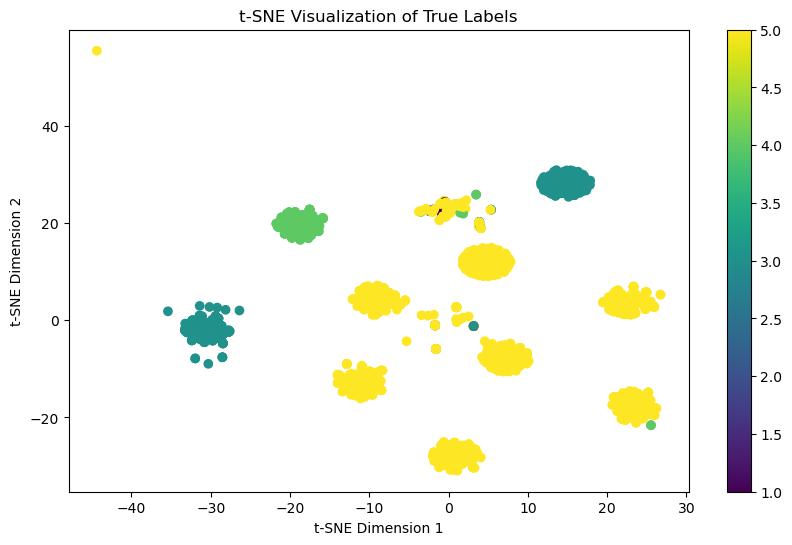

In [4]:
## using t-sne (alternative to pca) to visualize clusters according to true labels

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(itemset_features)

# # Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


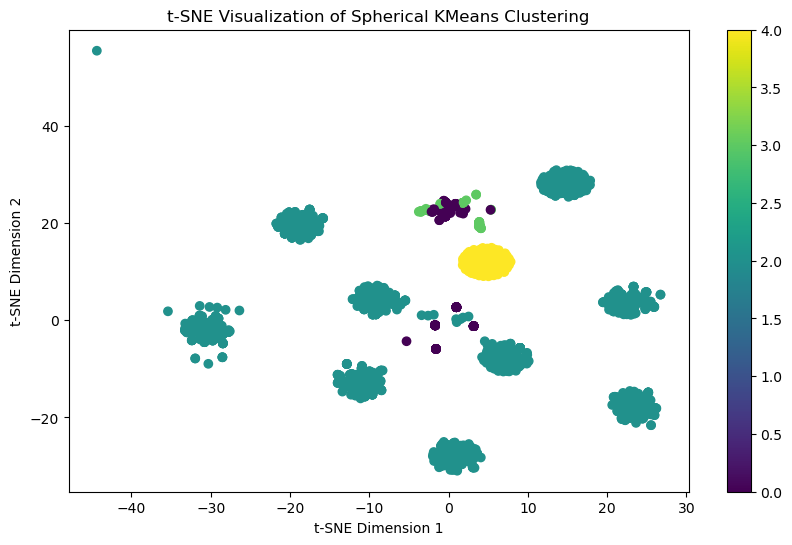

In [5]:
## using t-sne (alternative to pca) to visualize Spherical KMeans clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Spherical KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [6]:
# OPTIMISING DBSCAN PARAMETERS USING SILHOUETTE SCORE

from hyperopt import hp, fmin, tpe, Trials
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Define the search space
space = {
    'eps': hp.uniform('eps', 2, 8),
    'min_samples': hp.choice('min_samples', range(2,60))
}

# Define the objective function
def objective(params):
    dbscan = DBSCAN(**params)
    cluster_labels = dbscan.fit_predict(tsne_results)

    # Exclude noise points (labelled as -1) before computing the silhouette score
    non_noise_indices = np.where(cluster_labels != -1)[0]
    if len(non_noise_indices) == 0 or len(set(cluster_labels[non_noise_indices])) == 1:
        # Return a large negative value if there's only one cluster or all are noise 
        # since silhouette score can't be computed in these cases
        return -1

    # score = silhouette_score(itemset_features[non_noise_indices], cluster_labels[non_noise_indices], metric='cosine')
    score = silhouette_score(tsne_results[non_noise_indices], cluster_labels[non_noise_indices])
    return -score  # Negative score because fmin tries to minimize the objective

# Run the optimizer
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100  # Number of evaluations
)

best_min_samples = range(2, 60)[best['min_samples']]
best_eps = best['eps']
print("Best eps:", best['eps'])
print("Best min_samples:", best_min_samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.35trial/s, best loss: -0.8546896576881409]
Best eps: 2.0418359687482366
Best min_samples: 50


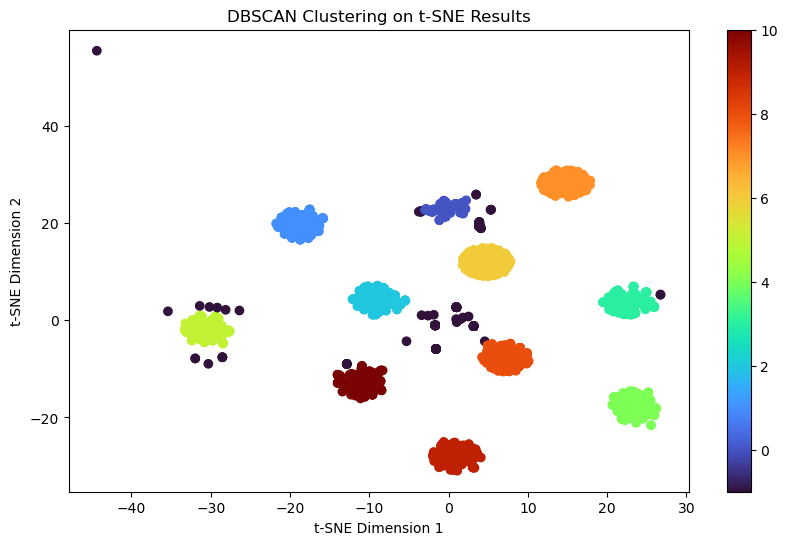

Adjusted Rand Index: 0.15851597406393061
Normalized Mutual Information: 0.49337793723281664
Homogeneity: 0.9529021061121814
Completeness: 0.3328604712491975
V-Measure: 0.4933779372328167
Silhouette Score: 0.9637359014687696


In [7]:
## performing DBSCAN on the data transformed by t-sne

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the t-SNE results
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Create a scatter plot to visualize the DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='turbo')
plt.colorbar()
plt.title('DBSCAN Clustering on t-SNE Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

non_noise_indices = np.where(dbscan_labels != -1)[0]
_ = compare_true_labels(true_labels[non_noise_indices], dbscan_labels[non_noise_indices], itemset_features[non_noise_indices])

In [8]:
## REMOVE OUTLIERS IDEA

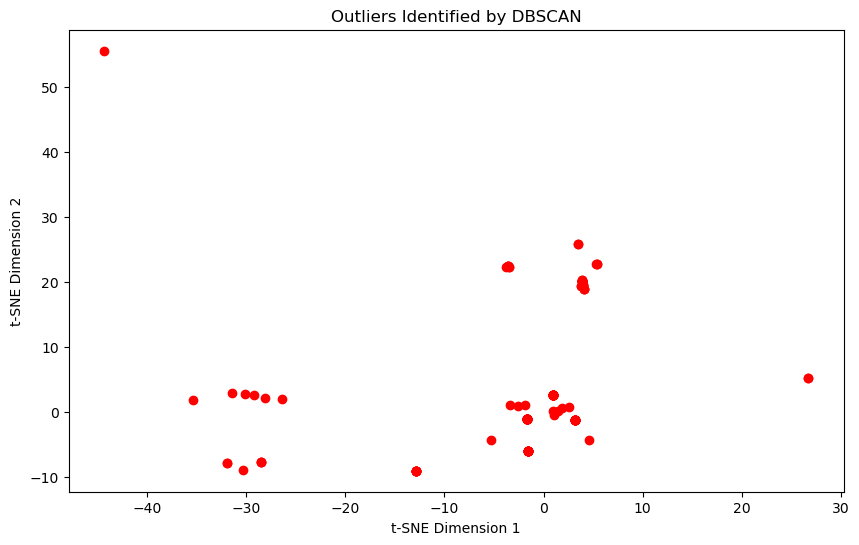

In [9]:
# Filter out the outlier points
outlier_points = tsne_results[dbscan_labels == -1]

# Create a scatter plot for the outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red')
plt.title('Outliers Identified by DBSCAN')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [10]:
outlier_index = np.where(dbscan_labels==-1)

filtered_data = np.delete(itemset_features, outlier_index, axis=0)
filtered_labels = np.delete(true_labels, outlier_index, axis=0)
print(len(filtered_labels), len(true_labels))

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
filtered_itemset_matrix = csr_matrix(filtered_data.astype(int))

spherical_kmeans = SphericalKMeans(
        n_clusters=11,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i = 0
excep_count = 0
while len(results)<10:
    try:
        filtered_sphkmeans_cluster_labels = spherical_kmeans.fit_predict(filtered_itemset_matrix)
        i+=1
        excep_count = 0
        print('\nRun #' + str(i))
        result = compare_true_labels(filtered_labels, filtered_sphkmeans_cluster_labels, filtered_data)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        excep_count+=1
        if excep_count>20: break
        print(e)
        continue 

2114 2269

Run #1
Adjusted Rand Index: 0.11226039631223828
Normalized Mutual Information: 0.36238948182262354
Homogeneity: 0.5823955286756461
Completeness: 0.2630279155590213
V-Measure: 0.3623894818226236
Silhouette Score: 0.6403944273299762

Run #2
Adjusted Rand Index: 0.25630399801816567
Normalized Mutual Information: 0.5602036968106268
Homogeneity: 0.9611069287042089
Completeness: 0.39530957262029
V-Measure: 0.5602036968106268
Silhouette Score: 0.574083920463585

Run #3
Adjusted Rand Index: 0.0713095764976219
Normalized Mutual Information: 0.3274700437531247
Homogeneity: 0.5148355323572145
Completeness: 0.2400925223319646
V-Measure: 0.3274700437531247
Silhouette Score: 0.6266502022431873

Run #4
Adjusted Rand Index: 0.10339990329661287
Normalized Mutual Information: 0.3450113961493653
Homogeneity: 0.5368107414917052
Completeness: 0.2541905838756436
V-Measure: 0.3450113961493654
Silhouette Score: 0.5509630436585711

Run #5
Adjusted Rand Index: 0.14230927891010997
Normalized Mutual In

In [11]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.1104080778468603
NMI: 0.3617465492445645
Homogeneity: 0.58108657737553
Completeness: 0.26261757654231765
V-Measure: 0.3617465492445645
Silhouette: 0.5914848347696369


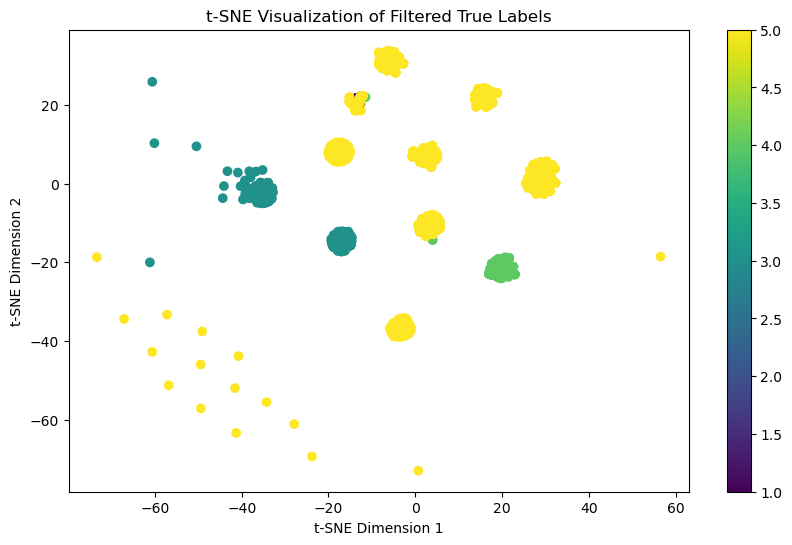

In [12]:
## using t-sne (alternative to pca) to visualize filtered true clusters

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(filtered_data)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


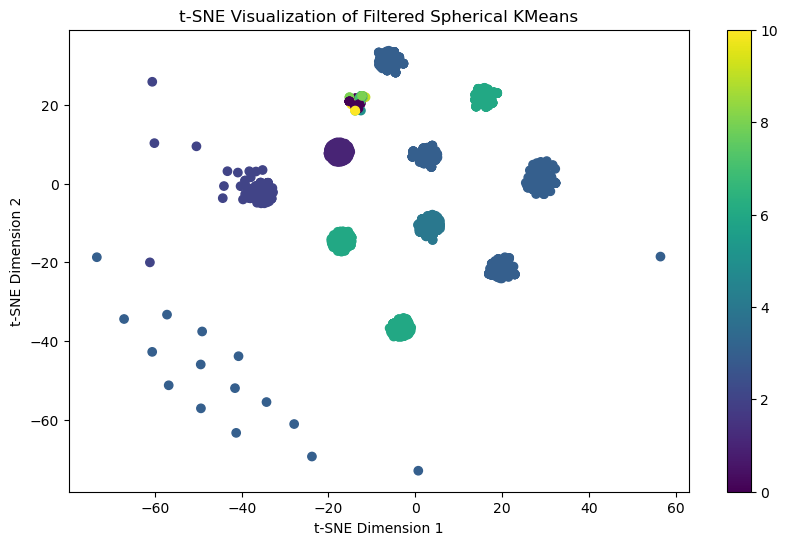

In [13]:
## using t-sne (alternative to pca) to visualize filtered SPHKMEANS clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered Spherical KMeans')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
